# <font color='red'>Clustering a sample Graph Data (Bipartite) </font>

### <font color='black'>Task 1 : Apply clustering algorithm to group similar actors</font>

 1. For this task consider only the actor nodes 
 2. Apply any clustering algorithm of your choice <br>
    Refer : https://scikit-learn.org/stable/modules/clustering.html
 3. Choose the number of clusters for which you have maximum score of <b>$Cost1*Cost2$</b><br>
 4. Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters 

 5. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 
 
 6. Fit the clustering algorithm with the opimal number_of_clusters and get the cluster number for each node <br>
 7. Convert the d-dimensional dense vectors of nodes into 2-dimensional using dimensionality reduction techniques (preferably TSNE)<br>
 8. Plot the 2d scatter plot, with the node vectors after step e and give colors to nodes such that same cluster nodes will have same color

### <font color='black'>Task 2 : Apply clustering algorithm to group similar movies</font>


1. For this task consider only the movie nodes
2. Apply any clustering algorithm of your choice
3.Choose the number of clusters for which you have maximum score of $Cost1*Cost2$ <br>

    Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br>

	
4. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of movie nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(number of unique actor nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}$ 
where N= number of clusters 



**Algorithm for actor nodes**

<pre>
	for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:
		algo = clustering_algorith(clusters=number_of_clusters)
        # you will be passing a matrix of size N*d where N number of actor nodes and d is dimension from gensim
		algo.fit(the dense vectors of actor nodes) 
        You can get the labels for corresponding actor nodes (algo.labels_)
        Create a graph for every cluster(ie., if n_clusters=3, create 3 graphs)
        (You can use ego_graph to create subgraph from the actual graph)
        compute cost1,cost2 
           (if n_cluster=3, cost1=cost1(graph1)+cost1(graph2)+cost1(graph3) # here we are doing summation
            cost2=cost2(graph1)+cost2(graph2)+cost2(graph3)
		computer the metric Cost = Cost1*Cost2
	return number_of_clusters which have maximum Cost
	</pre>

<br>

In [ ]:
#!pip install networkx==2.3

In [ ]:
#pip install stellargraph

In [ ]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
# you need to have tensorflow 
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph

In [ ]:
data=pd.read_csv('movie_actor_network.csv', index_col=False, names=['movie','actor'])

In [ ]:
edges = [tuple(x) for x in data.values.tolist()]

In [ ]:
edges=[(x,y) for (y,x) in edges]

number of nodes 4703
number of edges 9650


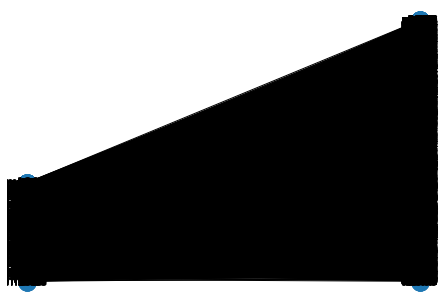

In [ ]:
B = nx.Graph()
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
B.add_edges_from(edges, label='acted')
A = list(nx.connected_component_subgraphs(B))[0]
print("number of nodes", A.number_of_nodes())
print("number of edges", A.number_of_edges())
l, r = nx.bipartite.sets(A)
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
  
nx.draw(A, pos=pos, with_labels=True)
plt.show()

In [ ]:
movies = []
actors = []
for i in B.nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)
print('number of movies ', len(movies))
print('number of actors ', len(actors))

number of movies  1292
number of actors  3411


In [ ]:

# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(B))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
    
]

walks = rw.run(nodes=list(B.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 4703


In [ ]:
from gensim.models import Word2Vec
model = Word2Vec(walks, size=128, window=5)

In [ ]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(4703, 128)

In [ ]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ B.node[node_id]['label'] for node_id in node_ids]

In [ ]:
print(node_ids[:15],end=" ")

['a973', 'a967', 'a964', 'a1731', 'a970', 'a969', 'a1028', 'a1057', 'a965', 'a1003', 'm1111', 'm1094', 'a966', 'a959', 'a988'] 

In [ ]:
movie_indices=np.array([node_ids.index(i) for i in node_ids if "m" in i])
actor_indices=np.array([node_ids.index(i) for i in node_ids if "a" in i])

In [ ]:
node_embeddings[movie_indices,:]

array([[ 0.02488567,  0.46206173, -0.37483412, ..., -2.8425584 ,
         1.5327905 , -1.5700046 ],
       [-0.18801181, -1.9845041 , -1.6057581 , ..., -3.9459608 ,
         0.17457967,  2.2740502 ],
       [-2.597275  , -1.1715989 , -2.5351958 , ..., -2.185388  ,
         2.5155528 ,  0.58445096],
       ...,
       [ 0.06192558, -0.01123548, -0.06025985, ..., -0.15168038,
        -0.06390478, -0.07541883],
       [ 0.01406115,  0.00526846, -0.10804561, ..., -0.27526873,
         0.03809485, -0.00808202],
       [-0.0196139 , -0.02494868, -0.02097885, ..., -0.15537818,
         0.10541569, -0.0644106 ]], dtype=float32)

In [ ]:
actor_nodes=[i for i in node_ids if "a" in i]
movie_nodes=[j for j in node_ids if "m" in j]
len(actor_nodes),len(movie_nodes)

(3411, 1292)

In [ ]:
def data_split(node_ids,node_targets,node_embeddings):
    '''In this function, we will split the node embeddings into actor_embeddings , movie_embeddings '''
    actor_nodes,movie_nodes=[i for i in node_ids if "a" in i],[j for j in node_ids if "m" in j]
    movie_indices=np.array([node_ids.index(i) for i in node_ids if "m" in i])
    actor_indices=np.array([node_ids.index(i) for i in node_ids if "a" in i])
    actor_embeddings,movie_embeddings=node_embeddings[actor_indices,:],node_embeddings[movie_indices,:]

    return actor_nodes,movie_nodes,actor_embeddings,movie_embeddings


In [ ]:
actor_nodes,movie_nodes,actor_embeddings,movie_embeddings=data_split(node_ids,node_targets,node_embeddings)

<font color='blue'>Calculating cost1</font>

Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br><br>
<br>

In [ ]:
def cost1(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    max_nodes,total_nodes=len(max(nx.connected_components(graph),key=len)),graph.number_of_nodes()
    cost1= max_nodes/(total_nodes*number_of_clusters)
    
    return cost1

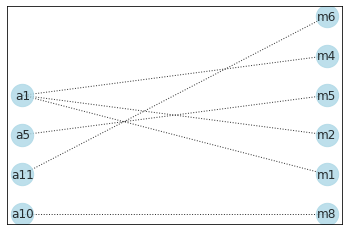

In [ ]:
import networkx as nx
from networkx.algorithms import bipartite
graded_graph= nx.Graph()
graded_graph.add_nodes_from(['a1','a5','a10','a11'], bipartite=0) # Add the node attribute "bipartite"
graded_graph.add_nodes_from(['m1','m2','m4','m6','m5','m8'], bipartite=1)
graded_graph.add_edges_from([('a1','m1'),('a1','m2'),('a1','m4'),('a11','m6'),('a5','m5'),('a10','m8')])
l={'a1','a5','a10','a11'};r={'m1','m2','m4','m6','m5','m8'}
pos = {}
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
nx.draw_networkx(graded_graph, pos=pos, with_labels=True,node_color='lightblue',alpha=0.8,style='dotted',node_size=500)

<font color='blue'>Calculating cost2</font>

Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 

In [ ]:
def cost2(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    num=sum([graph.degree(i) for i in graph.nodes if "a" in i ])
    den=len([j for j in graph.nodes if "m" in j])
    cost2= num/(den*number_of_clusters)
    
    return cost2

## ACTOR NODES - TASK 1 

In [80]:
actor_nodes,movie_nodes,actor_embeddings,movie_embeddings=data_split(node_ids,node_targets,node_embeddings)
num_clusters=[3, 5, 10, 30, 50, 100, 200, 500]
list_cost=[]
for k in num_clusters:
  kmeans = KMeans(n_clusters=k, random_state=0).fit(actor_embeddings)
  testcost1=0
  testcost2=0
  for i in range(0,k):
    test_nodes=np.array(actor_nodes).reshape(len(actor_nodes),)[kmeans.labels_==i].tolist()
    testgraph=nx.Graph()
    for j in test_nodes:
      testgraph.add_nodes_from(nx.ego_graph(B,j).nodes)
      testgraph.add_edges_from(nx.ego_graph(B,j).edges())
    testcost1=testcost1+cost1(testgraph,k)
    testcost2=testcost2+cost2(testgraph,k)
  print("cost1*cost2 value for cluster number "+str(k)+" : "+str(testcost1*testcost2))
  list_cost.append(testcost1*testcost2)
kmax_actor=num_clusters[list_cost.index(max(list_cost))]
print("maximum product of costs = "+str(max(list_cost)))
print("maximum value of cost for actors is obtained at:"+str(kmax_actor))
  
    




cost1*cost2 value for cluster number 3 : 3.726839562810361
cost1*cost2 value for cluster number 5 : 2.907376736588164
cost1*cost2 value for cluster number 10 : 2.2384816014528317
cost1*cost2 value for cluster number 30 : 1.718816913431825
cost1*cost2 value for cluster number 50 : 1.5130157840871183
cost1*cost2 value for cluster number 100 : 1.5353978353574838
cost1*cost2 value for cluster number 200 : 1.6252494919963854
cost1*cost2 value for cluster number 500 : 1.7528965577959468
maximum product of costs = 3.726839562810361
maximum value of cost for actors is obtained at:3


## MOVIE NODES TASK 2

In [81]:
actor_nodes,movie_nodes,actor_embeddings,movie_embeddings=data_split(node_ids,node_targets,node_embeddings)
num_clusters=[3, 5, 10, 30, 50, 100, 200, 500]
list_cost=[]
for k in num_clusters:
  kmeans = KMeans(n_clusters=k, random_state=0).fit(movie_embeddings)
  testcost1=0
  testcost2=0
  for i in range(0,k):
    test_nodes=np.array(movie_nodes).reshape(len(movie_nodes),)[kmeans.labels_==i].tolist()
    testgraph=nx.Graph()
    for j in test_nodes:
      testgraph.add_nodes_from(nx.ego_graph(B,j).nodes)
      testgraph.add_edges_from(nx.ego_graph(B,j).edges())
    testcost1=testcost1+cost1(testgraph,k)
    testcost2=testcost2+cost2(testgraph,k)
  print("cost1*cost2 value for cluster number "+str(k)+" : "+str(testcost1*testcost2))
  list_cost.append(testcost1*testcost2)
kmax_movie=num_clusters[list_cost.index(max(list_cost))]
print("maximum product of costs = "+str(max(list_cost)))
print("maximum values of cost for movies is obtained at:"+str(kmax_movie))
  
    




cost1*cost2 value for cluster number 3 : 8.52740259992235
cost1*cost2 value for cluster number 5 : 8.929217042468188
cost1*cost2 value for cluster number 10 : 9.130918448234134
cost1*cost2 value for cluster number 30 : 12.896780874641944
cost1*cost2 value for cluster number 50 : 14.573259834336646
cost1*cost2 value for cluster number 100 : 13.779011772890408
cost1*cost2 value for cluster number 200 : 12.819015971708774
cost1*cost2 value for cluster number 500 : 10.404480192188661
maximum product of costs = 14.573259834336646
maximum values of cost for movies is obtained at:50


<font color='blue'>Grouping similar actors</font>

In [100]:
kmeans = KMeans(n_clusters=kmax_actor, random_state=0).fit(actor_embeddings)


In [101]:
actor_nodes=np.array(actor_nodes)
actor_nodes=np.array((actor_nodes))
actor_data=np.vstack((actor_nodes,kmeans.labels_))
actorss=pd.DataFrame(actor_data.T,columns=["actor_node","group"])
actorss.head()

,actor_node,group
0,a973,0
1,a967,0
2,a1731,0
3,a964,0
4,a969,0


In [102]:
pip install MulticoreTSNE

<font color='blue'>Displaying similar actor clusters</font>

In [103]:
#https://github.com/DmitryUlyanov/Multicore-TSNE
from MulticoreTSNE import MulticoreTSNE as MTSNE

tsne = MTSNE(n_components=2,perplexity=30,learning_rate=200,n_jobs=16)
X_embeddingm = tsne.fit_transform(actor_embeddings)

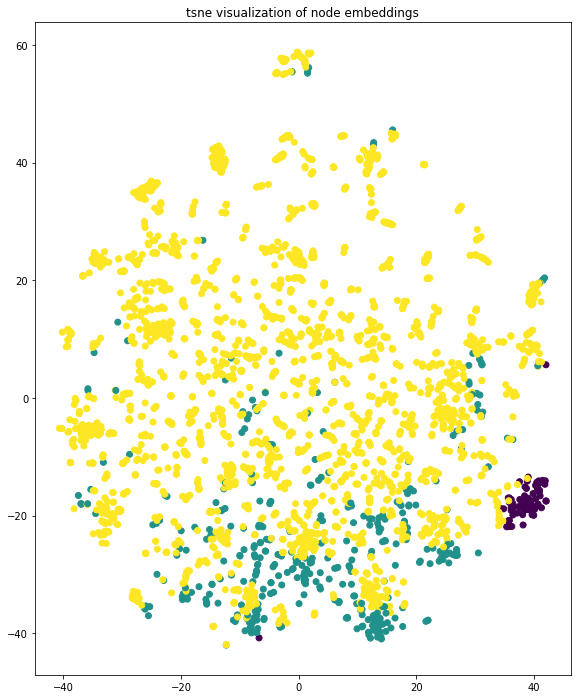

In [104]:

label_map = { l: i for i, l in enumerate(np.unique(list(kmeans.labels_)))}
node_colours = [ label_map[target] for target in list(kmeans.labels_)]

plt.figure(figsize=(12,12))
plt.axes().set(aspect="equal")
plt.scatter(X_embeddingm[:,0], 
            X_embeddingm[:,1], 
            c=node_colours, alpha=1)
plt.title('tsne visualization of node embeddings')

plt.show()

<font color='blue'>Grouping similar movies</font>

In [105]:
kmeans = KMeans(n_clusters=kmax_movie, random_state=0).fit(movie_embeddings)


In [106]:
movie_nodes=np.array(movie_nodes)
movie_data=np.vstack((movie_nodes,kmeans.labels_))
moviess=pd.DataFrame(movie_data.T,columns=["movie_node","group"])
moviess.head()

,movie_node,group
0,m1094,18
1,m1111,31
2,m67,47
3,m1100,48
4,m1095,10


<font color='blue'>Displaying similar movie clusters</font>

In [107]:
#https://github.com/DmitryUlyanov/Multicore-TSNE
from MulticoreTSNE import MulticoreTSNE as MTSNE

tsne = MTSNE(n_components=2,perplexity=30,learning_rate=200,n_jobs=16)
X_embeddingm = tsne.fit_transform(movie_embeddings)

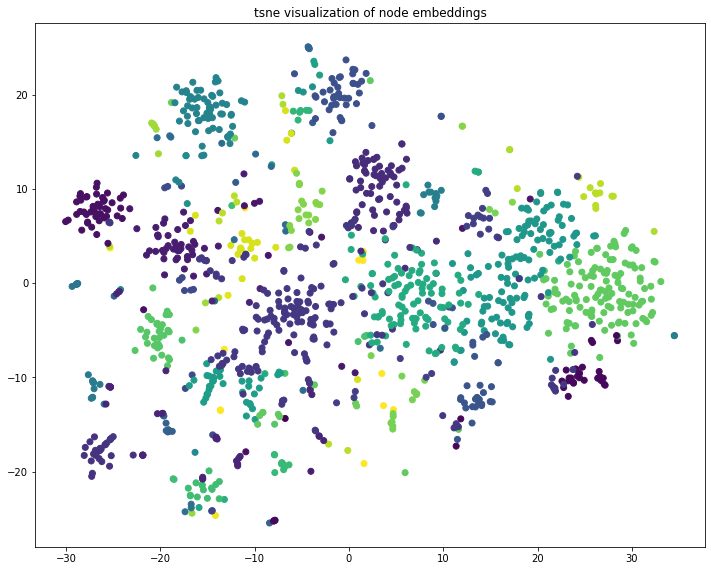

In [108]:

label_map = { l: i for i, l in enumerate(np.unique(list(kmeans.labels_)))}
node_colours = [ label_map[target] for target in list(kmeans.labels_)]

plt.figure(figsize=(12,12))
plt.axes().set(aspect="equal")
plt.scatter(X_embeddingm[:,0], 
            X_embeddingm[:,1], 
            c=node_colours, alpha=1)
plt.title('tsne visualization of node embeddings')

plt.show()